导包，gdal包依靠pip/conda无法直接安装，先下载whl文件，手动安装后，先导gdal再导其他包

In [12]:
!pip install --force-reinstall "D:/GDAL-3.4.3-cp310-cp310-win_amd64.whl"

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Processing d:\gdal-3.4.3-cp310-cp310-win_amd64.whl
  Attempting uninstall: GDAL
    Found existing installation: GDAL 3.4.3
    Uninstalling GDAL-3.4.3:
      Successfully uninstalled GDAL-3.4.3


In [1]:
from osgeo import gdal

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import math
from tqdm import tqdm
import shapely  
from shapely.geometry import LineString, Point, Polygon
import gc

cost matrix = dem_mean+dem_var+ecosystem service value(landuse data)+economy value(GDP distribution data)\
《遥感与 GIS 在油气管道线路选择中的应用研究》
网格大小：0.2\*0.2°（两万米）

处理mesh

In [4]:
mesh_intersect_all= gpd.read_file('../data/cost_matrix/mesh/intersect_mesh_country.gpkg',layer='intersect_mesh_country',encoding='utf-8')
mesh_intersect_all.head()

,id,left,top,right,bottom,cn_adcode,geometry
0,1570,74.6,37.2,74.8,37.0,100000,"POLYGON ((74.60000 37.20000, 74.80000 37.20000..."
1,1569,74.6,37.4,74.8,37.2,100000,"POLYGON ((74.60000 37.40000, 74.80000 37.40000..."
2,1564,74.6,38.4,74.8,38.2,100000,"POLYGON ((74.60000 38.40000, 74.80000 38.40000..."
3,1563,74.6,38.6,74.8,38.4,100000,"POLYGON ((74.60000 38.60000, 74.80000 38.60000..."
4,1562,74.6,38.8,74.8,38.6,100000,"POLYGON ((74.60000 38.80000, 74.80000 38.80000..."


In [14]:
mesh_intersect=mesh_intersect_all[mesh_intersect_all['cn_adcode']=='100000']
mesh_intersect.shape


(25105, 7)

In [15]:
mesh_intersect=mesh_intersect[['left', 'top', 'right', 'bottom','geometry']]
#mesh_intersect['middle'] = mesh_intersect['geometry'].apply(lambda x: x.centroid)
mesh_intersect['id'] = range(len(mesh_intersect))
mesh_intersect.head()

,left,top,right,bottom,geometry,id
0,74.6,37.2,74.8,37.0,"POLYGON ((74.60000 37.20000, 74.80000 37.20000...",0
1,74.6,37.4,74.8,37.2,"POLYGON ((74.60000 37.40000, 74.80000 37.40000...",1
2,74.6,38.4,74.8,38.2,"POLYGON ((74.60000 38.40000, 74.80000 38.40000...",2
3,74.6,38.6,74.8,38.4,"POLYGON ((74.60000 38.60000, 74.80000 38.60000...",3
4,74.6,38.8,74.8,38.6,"POLYGON ((74.60000 38.80000, 74.80000 38.80000...",4


In [16]:
mesh_intersect.to_file('../data/cost matrix/mesh/mesh_intersect.gpkg', layer='mesh_intersect', driver="GPKG")
# mesh_intersect.to_file('../data/cost matrix/mesh/mesh_intersect.shp', 
#              driver='ESRI Shapefile',
#              encoding='utf-8')

qgis->导入dem数据,伪彩色单波段->分区统计栅格数据->矢量图层：mesh_intersect，栅格图层：dem,统计量：mean,std->dem_statistics.gpkg

In [16]:
dem = gpd.read_file('../data/cost_matrix/dem/dem_statistics.gpkg', 
                     layer='dem_statistics',
                     encoding='utf-8')
print(dem.crs) # 查看数据对应的crs
dem.head() # 查看前5行


EPSG:4326


,left,top,right,bottom,id,_mean,_stdev,geometry
0,74.6,37.2,74.8,37.0,0,4761.751111,360.955229,"POLYGON ((74.60000 37.20000, 74.80000 37.20000..."
1,74.6,37.4,74.8,37.2,1,4729.630650,474.505025,"POLYGON ((74.60000 37.40000, 74.80000 37.40000..."
2,74.6,38.4,74.8,38.2,2,4369.292113,265.297540,"POLYGON ((74.60000 38.40000, 74.80000 38.40000..."
3,74.6,38.6,74.8,38.4,3,4421.485767,261.390972,"POLYGON ((74.60000 38.60000, 74.80000 38.60000..."
4,74.6,38.8,74.8,38.6,4,4464.096521,323.191762,"POLYGON ((74.60000 38.80000, 74.80000 38.80000..."


查看地形五分界数对应的归一化值

In [10]:
(1000-min(dem['_mean']))/(max(dem['_mean'])-min(dem['_mean']))

0.18379811650292163

In [11]:
(2000-min(dem['_mean']))/(max(dem['_mean'])-min(dem['_mean']))

0.3452633702975141

In [8]:
(4000-min(dem['_mean']))/(max(dem['_mean'])-min(dem['_mean']))


0.668193877886699

In [9]:
(6000-min(dem['_mean']))/(max(dem['_mean'])-min(dem['_mean']))


0.991124385475884

In [19]:
dem['_mean'].isnull().sum()


103

In [20]:
dem['_stdev'].isnull().sum()

103

简单填充法补全缺失

In [17]:
dem['_mean'].fillna(method='ffill', inplace=True)
dem['_stdev'].fillna(method='ffill', inplace=True)
dem['_mean'].isnull().sum()

0

用土地利用数据赋值生态系统服务价值

In [7]:
# 打开原始栅格文件
ds = gdal.Open('../data/cost_matrix/land_utilization/landuse_raw.tif', gdal.GA_Update)

# 读取第一个波段的数据
band = ds.GetRasterBand(1)
data = band.ReadAsArray()

In [8]:
data.shape

(135079, 161378)

In [10]:
np.unique(data[20000:21000,40000:41000])

array([ 2,  3, 10], dtype=uint8)

直接整体修改内存不足

In [9]:
#不同土地利用类型的碳足迹大小顺序为:居民点及工矿用地>交通用地>未利用地及特殊用地>农用地和水利用地
data = data.astype(np.float32)
data[data == 1] =   0.3  #农田
data[data == 2] =   0.5  #森林
data[data == 3] =   0.3  #灌木
data[data == 4] =   0.2  #草地
data[data == 5] =   1    #水体
data[data == 6] =   1    #冰雪
data[data == 7] =   0.2  #裸地
data[data == 8] =   1    #不透水面
data[data == 9] =   1    #湿地

MemoryError: Unable to allocate 81.2 GiB for an array with shape (135079, 161378) and data type float32

采用创建新栅格数据，赋值浮点数内存仍旧不足

In [5]:
# 打开原始栅格文件
ds = gdal.Open('../data/cost_matrix/land_utilization/landuse_raw.tif')

# 创建一个新的栅格文件，数据类型为GDT_Float32
driver = gdal.GetDriverByName('GTiff')
new_ds = driver.Create('../data/cost_matrix/land_utilization/landuse_new.tif', ds.RasterXSize, ds.RasterYSize, 1, gdal.GDT_Float32)
if new_ds is None:
    print('创建文件失败')
else:    

    # 设置新文件的地理变换和投影
    new_ds.SetGeoTransform(ds.GetGeoTransform())
    new_ds.SetProjection(ds.GetProjection())

    # 获取新文件的第一个波段
    new_band = new_ds.GetRasterBand(1)

    # 获取原始文件的第一个波段
    band = ds.GetRasterBand(1)

    # 获取栅格数据的块大小
    block_size = band.GetBlockSize()

    # 计算栅格数据的块数
    xsize = band.XSize
    ysize = band.YSize
    xblocks = (xsize // block_size[0]) + (1 if xsize % block_size[0] > 0 else 0)
    yblocks = (ysize // block_size[1]) + (1 if ysize % block_size[1] > 0 else 0)

    # 分块处理栅格数据
    for i in tqdm(range(xblocks)):
        for j in range(yblocks):
            xoff = i * block_size[0]
            yoff = j * block_size[1]
            xcount = min(block_size[0], xsize - xoff)
            ycount = min(block_size[1], ysize - yoff)
            
            # 读取一个块的数据
            data = band.ReadAsArray(xoff, yoff, xcount, ycount)
            
            # 修改数据
            data[data == 1] =   0.3  #农田
            data[data == 2] =   0.5  #森林
            data[data == 3] =   0.3  #灌木
            data[data == 4] =   0.2  #草地
            data[data == 5] =   1    #水体
            data[data == 6] =   1    #冰雪
            data[data == 7] =   0.2  #裸地
            data[data == 8] =   1    #不透水面
            data[data == 9] =   1    #湿地
            # ... 其他修改 ...
            
            # 将修改后的数据写回到新文件的块中
            new_band.WriteArray(data.astype(np.float32), xoff, yoff)

    # 将修改保存到新文件中
    new_ds.FlushCache()

    # 关闭文件
    ds = None
    new_ds = None

创建文件失败


采用分块修改，改变原始数据，但只能赋值整数，因此后续需要除以最大值

In [3]:
# 打开原始栅格文件
ds = gdal.Open('../data/cost_matrix/land_utilization/raw/landuse_raw.tif', gdal.GA_Update)

# 读取第一个波段的数据
band = ds.GetRasterBand(1)
data = band.ReadAsArray()
# 获取栅格数据的块大小
block_size = band.GetBlockSize()

# 计算栅格数据的块数
xsize = band.XSize
ysize = band.YSize
xblocks = (xsize // block_size[0]) + (1 if xsize % block_size[0] > 0 else 0)
yblocks = (ysize // block_size[1]) + (1 if ysize % block_size[1] > 0 else 0)

# 分块处理栅格数据
for i in tqdm(range(xblocks)):
    for j in range(yblocks):
        xoff = i * block_size[0]
        yoff = j * block_size[1]
        xcount = min(block_size[0], xsize - xoff)
        ycount = min(block_size[1], ysize - yoff)
        
        # 读取一个块的数据
        data = band.ReadAsArray(xoff, yoff, xcount, ycount)
        
        # 修改数据:赋值生态系统服务功能价值
        data[data == 1] =   8  #农田  79    
        data[data == 2] =   28  #森林 281
        data[data == 3] =   28  #灌木 281
        data[data == 4] =   12  #草地  117
        data[data == 5] =   45    #水体 454
        data[data == 6] =   1    #冰雪 14
        data[data == 7] =   1  #裸地 14
        data[data == 8] =   0    #不透水面 0
        data[data == 9] =   55    #湿地 548
        # ... 其他修改 ...
        
        # 将修改后的数据写回到块中
        band.WriteArray(data, xoff, yoff)

# 将修改保存到文件中
ds.FlushCache()

# 关闭文件
ds = None

100%|██████████| 316/316 [02:04<00:00,  2.54it/s]


In [3]:
ds = gdal.Open('../data/cost_matrix/land_utilization/raw/landuse_raw.tif', gdal.GA_Update)

# 读取第一个波段的数据
band = ds.GetRasterBand(1)
data = band.ReadAsArray()
np.unique(data[10000:21000,30000:41000])

array([ 0,  1, 12, 28, 45, 55], dtype=uint8)

及时清除变量，释放内存

In [6]:
gc.collect()


811

qgis-->分区统计-->土地利用因子栅格数据在mesh_intersect矢量数据上的均值

In [18]:
landuse_cost_statistic = gpd.read_file('../data/cost_matrix/land_utilization/raw/landuse_ecosystem.geojson'
)


In [5]:
landuse_cost_statistic.head()

,fid,left,top,right,bottom,id,area,_mean,geometry
0,1,74.6,37.2,74.8,37.0,0,3.946206e+08,5.657205,"POLYGON ((-2563429.04496 4997026.07599, -25474..."
1,2,74.6,37.4,74.8,37.2,1,3.935942e+08,2.765838,"POLYGON ((-2555272.95084 5017040.37701, -25393..."
2,3,74.6,38.4,74.8,38.2,2,3.883894e+08,5.742285,"POLYGON ((-2514551.79117 5116966.31522, -24988..."
3,4,74.6,38.6,74.8,38.4,3,3.873340e+08,4.871633,"POLYGON ((-2506418.79261 5136923.93252, -24907..."
4,5,74.6,38.8,74.8,38.6,4,3.862738e+08,6.455610,"POLYGON ((-2498289.32878 5156872.87437, -24826..."


归一化

土地的经济价值： http://jer.whu.edu.cn/jjgc/18/2015-09-18/1741.html
GDP分布数据：中国GDP空间分布公里网格数据集 数据来源于资源环境科学数据注册与出版系统 http://www.gis5g.com/data/gdpsj?id=262

In [19]:
GDP_statistic = gpd.read_file('../data/cost_matrix/GDP/GDP_statistic.geojson'
)
GDP_statistic.head()

,fid,left,top,right,bottom,id,area,_mean,geometry
0,1,74.6,37.2,74.8,37.0,0,3.946206e+08,2.858209,"POLYGON ((-2563429.04496 4997026.07599, -25474..."
1,2,74.6,37.4,74.8,37.2,1,3.935942e+08,2.294643,"POLYGON ((-2555272.95084 5017040.37701, -25393..."
2,3,74.6,38.4,74.8,38.2,2,3.883894e+08,4.200000,"POLYGON ((-2514551.79117 5116966.31522, -24988..."
3,4,74.6,38.6,74.8,38.4,3,3.873340e+08,5.671233,"POLYGON ((-2506418.79261 5136923.93252, -24907..."
4,5,74.6,38.8,74.8,38.6,4,3.862738e+08,6.468912,"POLYGON ((-2498289.32878 5156872.87437, -24826..."


<Axes: ylabel='Frequency'>

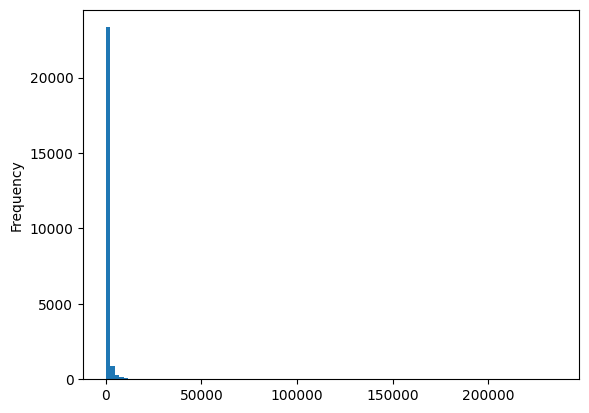

In [4]:
GDP_statistic['_mean'].plot.hist(bins=100)  #极值较大，取对数

In [20]:
GDP_statistic['_mean'].fillna(method='ffill', inplace=True)   #填充缺失值

In [11]:
GDP_statistic['_mean'].min()

0.0

<Axes: ylabel='Frequency'>

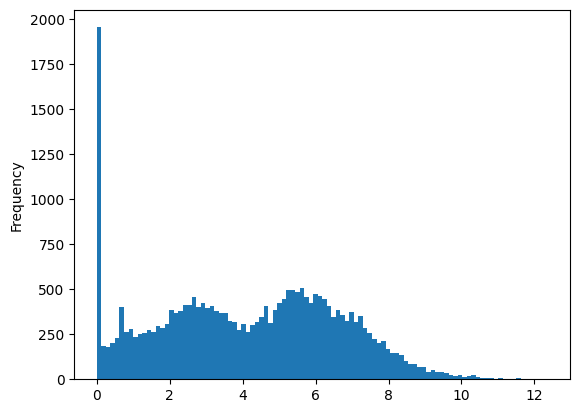

In [11]:
np.log(GDP_statistic['_mean']+1).plot.hist(bins=100)

In [21]:
GDP_statistic['log_mean']=np.log(GDP_statistic['_mean']+1)

归一化与合并

In [22]:
def minmax(column):
    return (column-column.min())/(column.max()-column.min())
mesh_factor=dem.copy()
mesh_factor['dem_mean_factor']=minmax(mesh_factor['_mean'])
mesh_factor['dem_std_factor']=minmax(mesh_factor['_stdev'])
mesh_factor['ecosystem_factor']=minmax(landuse_cost_statistic['_mean'])
mesh_factor['economic_factor']=minmax(GDP_statistic['log_mean'])
mesh_factor.head()

,left,top,right,bottom,id,_mean,_stdev,geometry,dem_mean_factor,dem_std_factor,ecosystem_factor,economic_factor
0,74.6,37.2,74.8,37.0,0,4761.751111,360.955229,"POLYGON ((74.60000 37.20000, 74.80000 37.20000...",0.791190,0.330536,0.096223,0.109151
1,74.6,37.4,74.8,37.2,1,4729.630650,474.505025,"POLYGON ((74.60000 37.40000, 74.80000 37.40000...",0.786004,0.434617,0.036484,0.096385
2,74.6,38.4,74.8,38.2,2,4369.292113,265.297540,"POLYGON ((74.60000 38.40000, 74.80000 38.40000...",0.727822,0.242855,0.097981,0.133278
3,74.6,38.6,74.8,38.4,3,4421.485767,261.390972,"POLYGON ((74.60000 38.60000, 74.80000 38.60000...",0.736249,0.239274,0.079992,0.153419
4,74.6,38.8,74.8,38.6,4,4464.096521,323.191762,"POLYGON ((74.60000 38.80000, 74.80000 38.80000...",0.743129,0.295921,0.112719,0.162549


In [23]:
mesh_factor=mesh_factor[['id','left', 'top', 'right', 'bottom','geometry','dem_mean_factor','dem_std_factor','ecosystem_factor','economic_factor']]

检查缺失值并填充

In [24]:
mesh_factor['dem_mean_factor'].isnull().sum()


0

In [25]:
mesh_factor['dem_std_factor'].isnull().sum()

0

In [26]:
mesh_factor['ecosystem_factor'].isnull().sum()

78

In [27]:
mesh_factor['economic_factor'].isnull().sum()

0

In [28]:
mesh_factor['ecosystem_factor'].fillna(method='ffill', inplace=True)

In [25]:
mesh_factor.to_csv('../data/cost_matrix/factor_mesh/cost_matrix_3.csv',index=False)
#最好不存csv，因为原来的geometry是shapely对象，存csv后会变成字符串，读取后再保存成gpkg需要重新转换

In [4]:
mesh_factor=pd.read_csv('../data/cost_matrix/factor_mesh/cost_matrix_3.csv',index_col=0)
mesh_factor.head()

,left,top,right,bottom,geometry,dem_mean_factor,dem_std_factor,ecosystem_factor,economic_factor
id,,,,,,,,,
0,74.6,37.2,74.8,37.0,"POLYGON ((74.6 37.2, 74.8 37.2, 74.8 37, 74.6 ...",0.791190,0.330536,0.096223,0.109151
1,74.6,37.4,74.8,37.2,"POLYGON ((74.6 37.4, 74.8 37.4, 74.8 37.199999...",0.786004,0.434617,0.036484,0.096385
2,74.6,38.4,74.8,38.2,"POLYGON ((74.6 38.4, 74.8 38.4, 74.8 38.199999...",0.727822,0.242855,0.097981,0.133278
3,74.6,38.6,74.8,38.4,"POLYGON ((74.6 38.599999999999994, 74.8 38.599...",0.736249,0.239274,0.079992,0.153419
4,74.6,38.8,74.8,38.6,"POLYGON ((74.6 38.8, 74.8 38.8, 74.8 38.599999...",0.743129,0.295921,0.112719,0.162549


In [29]:
mesh_factor['cost_factor']=0.1*mesh_factor['dem_mean_factor']+0.5*mesh_factor['dem_std_factor']+0.2*mesh_factor['ecosystem_factor']+0.2*mesh_factor['economic_factor']
mesh_factor.head()

,id,left,top,right,bottom,geometry,dem_mean_factor,dem_std_factor,ecosystem_factor,economic_factor,cost_factor
0,0,74.6,37.2,74.8,37.0,"POLYGON ((74.60000 37.20000, 74.80000 37.20000...",0.791190,0.330536,0.096223,0.109151,0.285462
1,1,74.6,37.4,74.8,37.2,"POLYGON ((74.60000 37.40000, 74.80000 37.40000...",0.786004,0.434617,0.036484,0.096385,0.322483
2,2,74.6,38.4,74.8,38.2,"POLYGON ((74.60000 38.40000, 74.80000 38.40000...",0.727822,0.242855,0.097981,0.133278,0.240461
3,3,74.6,38.6,74.8,38.4,"POLYGON ((74.60000 38.60000, 74.80000 38.60000...",0.736249,0.239274,0.079992,0.153419,0.239944
4,4,74.6,38.8,74.8,38.6,"POLYGON ((74.60000 38.80000, 74.80000 38.80000...",0.743129,0.295921,0.112719,0.162549,0.277327


<Axes: ylabel='Frequency'>

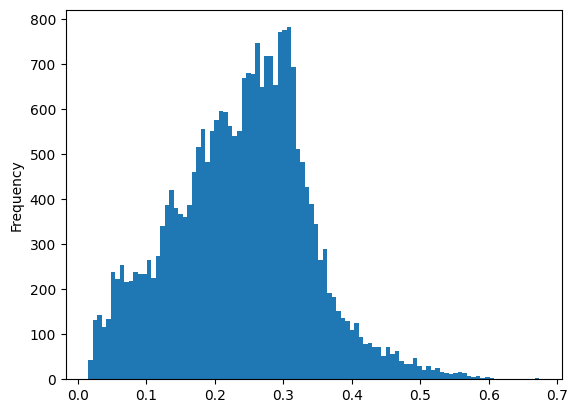

In [7]:
mesh_factor['cost_factor'].plot.hist(bins=100)

In [6]:
mesh_factor['cost_factor'].isnull().sum()

0

In [30]:
#上下左右经纬度需要四舍五入
mesh_factor['left']=round(mesh_factor['left'],1)
mesh_factor['top']=round(mesh_factor['top'],1)
mesh_factor['right']=round(mesh_factor['right'],1)
mesh_factor['bottom']=round(mesh_factor['bottom'],1)

渤海外围网格去除，以防路径走外围

In [9]:
mesh_factor.shape

(25105, 10)

In [31]:
mesh_factor=mesh_factor[~((mesh_factor['bottom']==38.4) & (mesh_factor['left']==120.8))]
mesh_factor.shape

(25104, 11)

用于qgis可视化

In [32]:
mesh_factor['geometry'].info()
is_string = mesh_factor['geometry'].apply(lambda x: isinstance(x, str))
is_string.sum()

<class 'geopandas.geoseries.GeoSeries'>
Index: 25104 entries, 0 to 25104
Series name: geometry
Non-Null Count  Dtype   
--------------  -----   
25104 non-null  geometry
dtypes: geometry(1)
memory usage: 392.2 KB


0

In [33]:
# mesh_factor=gpd.GeoDataFrame(mesh_factor, geometry='geometry')
mesh_factor.to_file('../data/cost_matrix/factor_mesh/mesh_factor_3.gpkg', layer='mesh_factor', driver="GPKG")

加上省会信息，用于A*

In [34]:
def check_value(value):
    if value.size == 0 or value == "":
        raise ValueError("值为空，出现错误异常")

def find_limits(number, interval):

    lower_limit = round((number // interval) * interval,1)
    upper_limit = round(lower_limit + interval,1)
    return lower_limit, upper_limit 

capital_coordination=gpd.read_file('../data/geodata process/gpd_capital_coordination.json')

for i in range(len(capital_coordination)):
    left,_=find_limits(capital_coordination.loc[i,'longitude'], 0.2)
    bottom,_=find_limits(capital_coordination.loc[i,'latitude'], 0.2)
    #找到省会坐标对应的网格的索引
    index=mesh_factor[np.isclose(mesh_factor['left'],left)&np.isclose(mesh_factor['bottom'],bottom)].index
    try:
        check_value(index)
    except ValueError as e:
        print(f"错误: {e}")
    #将省会名称赋值给对应的网格
    mesh_factor.loc[index,'capital']=capital_coordination.loc[i,'index']
    
    

In [35]:
mesh_factor.capital.info() #capital个数完整

<class 'pandas.core.series.Series'>
Index: 25104 entries, 0 to 25104
Series name: capital
Non-Null Count  Dtype 
--------------  ----- 
34 non-null     object
dtypes: object(1)
memory usage: 908.3+ KB


In [36]:
cost_matrix=pd.DataFrame(mesh_factor[['id','left','top','right','bottom','cost_factor','capital']])
cost_matrix.to_csv('../data/cost_matrix/factor_mesh/cost_matrix_3.csv')

In [23]:
cost_matrix[~cost_matrix.capital.isnull()]


,id,left,top,right,bottom,cost_factor,capital
5314,5314,87.6,43.8,87.8,43.6,0.143745,Xinjiang
5659,5659,91.0,30.0,91.2,29.8,0.267883,Tibet
11097,11097,101.6,36.6,101.8,36.4,0.129572,Qinghai
11395,11395,102.6,25.2,102.8,25.0,0.337125,Yunnan
12140,12140,104.0,30.8,104.2,30.6,0.309153,Sichuan
12377,12377,103.6,36.2,103.8,36.0,0.194495,Gansu
13067,13067,106.2,38.6,106.4,38.4,0.200397,Ningxia
13327,13327,106.6,26.6,106.8,26.4,0.271913,Guizhou
13377,13377,106.4,29.6,106.6,29.4,0.337039,Chongqing
14391,14391,108.2,23.0,108.4,22.8,0.311661,Guangxi


18km^2的为中国地形起伏度最佳统计窗口

［5］ 程维明周成虎柴慧霞等．中国陆地地貌基本形态类型定量提取与分析［J］．地球信息科学学报200911（16）：725-736．
［6］ 郎玲玲程维明朱启疆等．多尺度 DEM 提取地势起伏度的对比分析－－－以福建低山丘陵区为例［J］．地球信息科学2007
9（6）：1-7．